In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from src.data_processing.processors.TrainingProcessor import TrainingProcessor
from src.utilities.pandas_helpers import filter_columns_by_search, flatten_dataframe

In [3]:
%load_ext autoreload 
%autoreload 2 

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## load preprocessed data

In [5]:
data = pd.read_parquet("/Users/mds8301/iterm_data_storage/full_dataset.parquet.gzip")

## agg data down to max and min for each day

In [6]:
def calculate_max_min_signal(df):
    
    events = filter_columns_by_search(data, 'event')
    actions = filter_columns_by_search(data, 'action')
    mouse = filter_columns_by_search(data, 'mouse')
    sensors = filter_columns_by_search(data, 'sensor')
    return (
        df
        .groupby(by = mouse+events+actions+sensors+['day', 'trial_count'], as_index = False).agg({"signal": ["max", "min"]})
        .pipe(flatten_dataframe)
        .rename(columns = lambda c: c.strip("_"))
        .drop(columns ='index')
    )

max_min = calculate_max_min_signal(data)

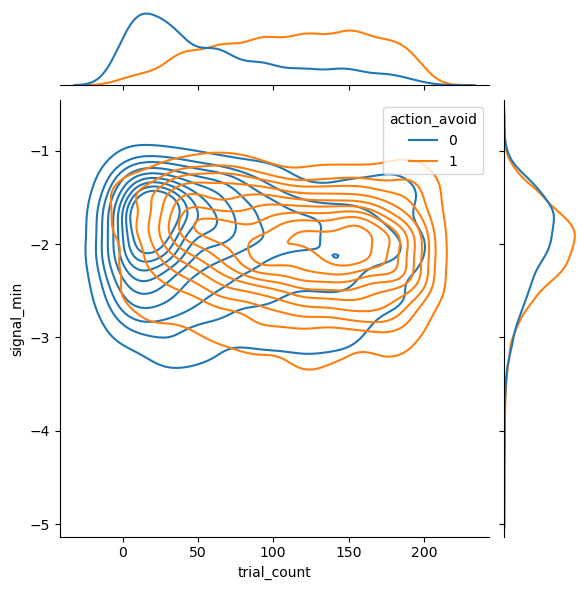

In [7]:
da = max_min.query("sensor_DA == 1")
sns.jointplot(
    data=da,
    x="trial_count", y="signal_min", hue="action_avoid",
    kind="kde"
)

In [124]:
classifer_processor = (TrainingProcessor(max_min[::10])
                       .drop_colinear_columns('action_escape')
                       .query_sensor_and_sort_trials_by_subject(sensor = 'DA')
                       .split_train_val_test_by_subject(target = 'action_avoid')
                       .save_subjects_by_category(path = "/Users/mds8301/iterm_data_storage")
)
num_features = classifer_processor.train_x.columns.shape[0]
num_features

22

In [191]:
tf.keras.backend.clear_session()

In [198]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (classifer_processor.train_x.shape[1],)),
    # tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc-roc')]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
base_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=metrics)
base_model.fit(classifer_processor.train_x, classifer_processor.train_y,
          epochs=200, batch_size=32, 
          validation_data=(classifer_processor.val_x, classifer_processor.val_y))

Epoch 1/200
14/14 [==============================] - 2s 78ms/step - loss: 0.5827 - accuracy: 0.7286 - precision: 0.7444 - recall: 0.8171 - auc-roc: 0.7644 - val_loss: 0.6362 - val_accuracy: 0.6163 - val_precision: 0.5753 - val_recall: 0.9545 - val_auc-roc: 0.7919
Epoch 2/200
14/14 [==============================] - 0s 23ms/step - loss: 0.5678 - accuracy: 0.7190 - precision: 0.7832 - recall: 0.7195 - auc-roc: 0.7871 - val_loss: 0.8059 - val_accuracy: 0.6047 - val_precision: 0.5658 - val_recall: 0.9773 - val_auc-roc: 0.7930
Epoch 3/200
14/14 [==============================] - 0s 19ms/step - loss: 0.5812 - accuracy: 0.7405 - precision: 0.7473 - recall: 0.8415 - auc-roc: 0.7818 - val_loss: 0.5945 - val_accuracy: 0.6977 - val_precision: 0.6500 - val_recall: 0.8864 - val_auc-roc: 0.7963
Epoch 4/200
14/14 [==============================] - 0s 16ms/step - loss: 0.5332 - accuracy: 0.7452 - precision: 0.7643 - recall: 0.8171 - auc-roc: 0.8060 - val_loss: 0.6743 - val_accuracy: 0.6512 - val_preci

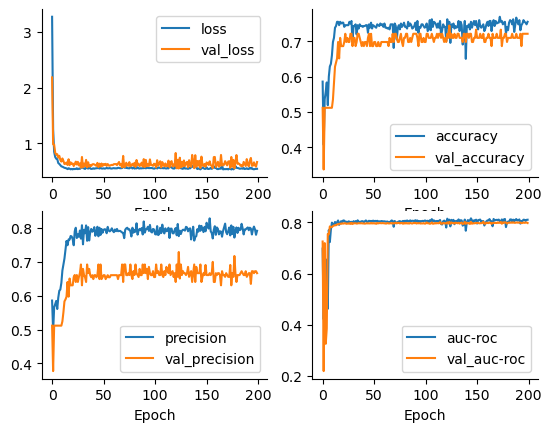

In [197]:
fig, ax = plt.subplots(2,2)
    
def plot_metrics(*metrics, model, title, ax):
    for metric in metrics:
        ax.plot(model.history.history[f'{metric}'], label=f'{metric}')
        # ax.title(f'{title}')
        # plt.yscale('log')
        ax.set_xlabel('Epoch')
        ax.legend()
        sns.despine()

plot_metrics('loss', 'val_loss', model = base_model, title = 'Loss', ax = ax[0,0])
plot_metrics('accuracy', 'val_accuracy', model = base_model, title = 'Accuracy', ax = ax[0,1])
plot_metrics('precision', 'val_precision', model = base_model, title = 'Precision', ax = ax[1,0])
plot_metrics('auc-roc', 'val_auc-roc', model = base_model, title = 'Recall', ax = ax[1,1])

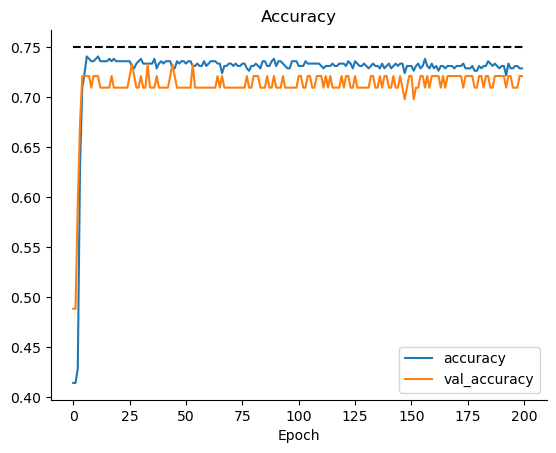

In [170]:
plot_metrics('accuracy', 'val_accuracy', title='Accuracy')
plt.hlines(0.75,0, 200, colors='k', linestyles='--')

In [267]:
predictions = model.predict(classifer_processor.test_x)
labels = np.where(predictions > 0.5, 1, 0)


5/5 [==============================] - 0s 3ms/step


In [274]:
model_eval = model.evaluate(classifer_processor.test_x, classifer_processor.test_y)

5/5 [==============================] - 0s 14ms/step - loss: 0.7852 - accuracy: 0.6343 - precision: 0.6714 - recall: 0.6438 - auc-roc: 0.6541


AttributeError: 'list' object has no attribute 'keys'

In [204]:
all_test_data = classifer_processor.test_x.assign(true_avoids = classifer_processor.test_y,
                                                  predicted_avoids = labels)
all_test_data

,mouse_id_0,mouse_id_1,mouse_id_2,mouse_id_3,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,...,event_cue,event_escape,event_avoid,event_shock,day,trial_count,signal_max,signal_min,true_avoids,predicted_avoids
115,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,3.976358,-1.921990,0,0
133,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,2,2.473836,-2.182656,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,6,2.717809,-1.625869,0,0
116,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,10,5.282989,-1.756946,0,0
134,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,12,3.465084,-1.416164,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,7,151,3.155685,-2.238259,1,1
266,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,7,154,4.026317,-1.630844,0,1
260,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,7,156,2.950382,-1.859217,1,1
241,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,7,163,3.760271,-1.666295,1,1


<Axes: xlabel='avoid', ylabel='trial_count'>

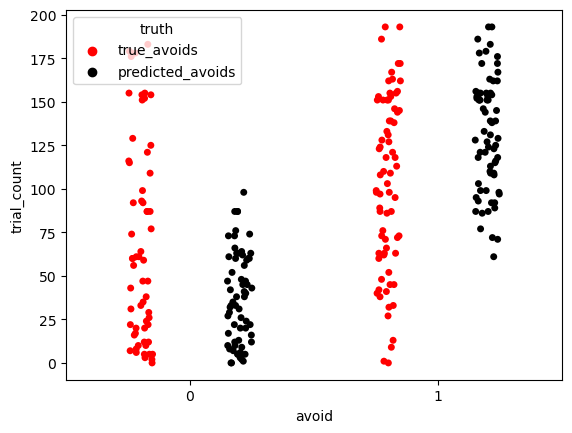

In [232]:
selected_data = all_test_data.melt(
    id_vars = all_test_data.drop(columns = ['true_avoids', 'predicted_avoids']).columns,
     value_vars = ['true_avoids', 'predicted_avoids'], 
     value_name = 'avoid',
     var_name = 'truth')

sns.stripplot(data = selected_data, 
              x = 'avoid', 
              y = 'trial_count', 
              jitter = True, 
              dodge = True,
              hue = 'truth', 
              palette = ['red', 'black'])

<Axes: xlabel='avoid', ylabel='trial_count'>

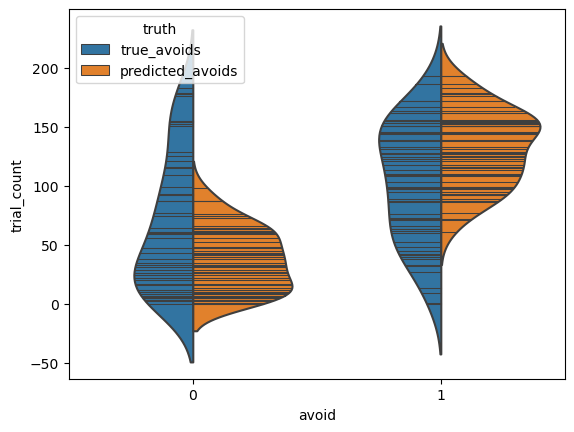

In [239]:
sns.violinplot(data = selected_data, 
              x = 'avoid', 
              y = 'trial_count',
              inner = 'stick',
              split = True,
              hue = 'truth',
              alpha = 0.5)

<Axes: xlabel='trial_count', ylabel='avoid'>

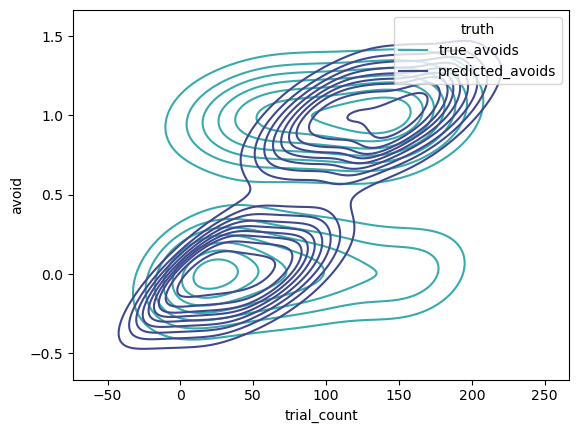

In [259]:
sns.kdeplot(data = selected_data, x = 'trial_count',
            y = 'avoid', 
            hue = 'truth',
            # fill = True,
            thresh = 0.1,
            # levels = 1000,
            palette = 'mako_r')


<Axes: xlabel='avoid', ylabel='trial_count'>

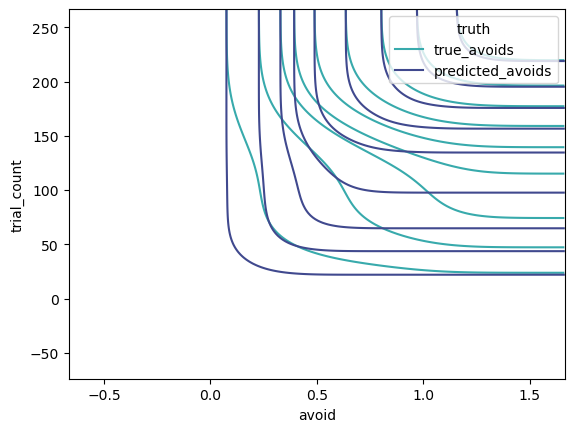

In [262]:
sns.kdeplot(data = selected_data, 
            x = 'avoid',
            y = 'trial_count', 
            hue = 'truth',
            cumulative = True,
            common_norm = True, 
            # fill = True,
            thresh = 0.1,
            # levels = 1000,
            palette = 'mako_r')


In [230]:

selected_data.head()

,mouse_id_0,mouse_id_1,mouse_id_2,mouse_id_3,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,...,event_cue,event_escape,event_avoid,event_shock,day,trial_count,signal_max,signal_min,truth,avoid
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,3.976358,-1.921990,true_avoids,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,2,2.473836,-2.182656,true_avoids,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,6,2.717809,-1.625869,true_avoids,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,10,5.282989,-1.756946,true_avoids,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,12,3.465084,-1.416164,true_avoids,0


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data_scalar = StandardScaler().fit_transform(num_data)
pca = PCA(n_components=2).fit_transform(data_scalar)

In [113]:
pca_df = pd.DataFrame(pca, columns=['PC1', 'PC2']).assign(avoided=max_min['action_avoid'], 
                                                          day = max_min['day'])

<Axes: xlabel='PC1', ylabel='PC2'>

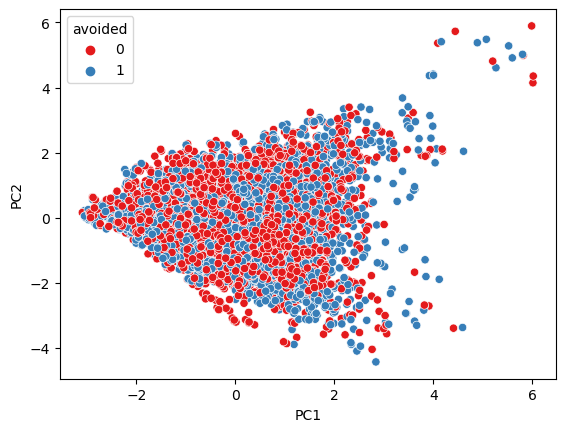

In [115]:
sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2', hue = 'avoided', palette = 'Set1')